# Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np


In [4]:
df = pd.read_csv("../data/COMP1801_Coursework_Dataset_Corrected.csv")
print(f"Number of rows = {df.shape[0]} & Columns = {df.shape[1]}:")
print(df.head()) 
print(df.info())  
print(df.describe())

Number of rows = 1000 & Columns = 16:
   Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1107.81    Valve    singleGrain           27        2.64       8.08   
1   1226.13    Valve       colGrain           24        4.06       1.11   
2   1914.12    Blade    singleGrain           20        4.36       8.54   
3   1240.83    Valve    singleGrain           14        3.59       8.83   
4   1599.40   Nozzle    singleGrain           22        3.06       3.04   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          23.35    60.65  19.76    15.18       4.41             7   
1          24.98    52.47  31.63    12.32       3.58            30   
2          34.71    60.98  26.56    11.60       0.86            22   
3          21.61    54.13  26.71    17.81       1.35            10   
4          29.65    62.88  24.06    12.08       0.98            21   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0  

In [5]:
desc = df.describe().T
desc['Data Type'] = df.dtypes
desc = desc[['Data Type', 'mean', 'std','min','max']]
desc = desc.rename(columns={
    'mean':'Mean',
    'std' : 'Std Dev',
    'min' : 'Min' ,
    'max' : 'Max'
})


In [6]:
# Create a separate DataFrame for categorical features
cat_features = pd.DataFrame({
    'Attribute': ['partType', 'microstructure', 'seedLocation', 'castType'],
    'Data Type': ['Categorical'] * 4,
    'Description': [
        'Type of metal part (Blade, Nozzle, Valve, Block)',
        "Observed microstructure ('equiGrain', 'singleGrain', 'colGrain')",
        'Growth start location in mould (Top, Bottom)',
        'Type of casting method used (Die, Investment, Continuous)'
    ],
    'Mean': ['-'] * 4,
    'Std Dev': ['-'] * 4,
    'Min': ['-'] * 4,
    'Max': ['-'] * 4
})


In [7]:
numeric_table = desc.reset_index().rename(columns={'index': 'Attribute'})
numeric_table.insert(2, 'Description', ['Measured lifespan of a metal part (hours)',
                                        'Speed of liquid metal cooling (K/s)',
                                        'Time immersed in water (s)',
                                        'Time worked with hammer (s)',
                                        'Heat treatment duration (min)',
                                        'Nickel composition (%)',
                                        'Iron composition (%)',
                                        'Cobalt composition (%)',
                                        'Chromium composition (%)',
                                        'Number of small defects',
                                        'Number of large defects',
                                        'Number of sliver defects'])


eda_table = pd.concat([numeric_table, cat_features], ignore_index=True)


In [8]:
from IPython.display import display, HTML

display(HTML(eda_table.to_html(index=False, justify='center')))


Attribute,Data Type,Description,Mean,Std Dev,Min,Max
Lifespan,float64,Measured lifespan of a metal part (hours),1281.80612,341.136845,359.71,2046.41
coolingRate,int64,Speed of liquid metal cooling (K/s),17.615,7.480156,5.0,30.0
quenchTime,float64,Time immersed in water (s),2.69331,1.303057,0.51,5.0
forgeTime,float64,Time worked with hammer (s),5.48704,2.604827,1.01,9.97
HeatTreatTime,float64,Heat treatment duration (min),30.75928,17.054664,1.05,59.99
Nickel%,float64,Nickel composition (%),59.64644,5.745955,50.01,69.98
Iron%,float64,Iron composition (%),25.17329,7.312363,7.95,42.79
Cobalt%,float64,Cobalt composition (%),12.41628,4.222616,5.04,20.0
Chromium%,float64,Chromium composition (%),2.76399,1.307658,0.5,4.99
smallDefects,int64,Number of small defects,16.659,11.885874,0.0,59.0


### Dataset obersvations:

1. We have 12 numerical and 4 categorical features
2. We can see that there are some features like 'Lifespan', 'HeatTreatTime' and 'Nickel%' that have quite a variation in their scales and this suggests we must **scale the dataset** using some sort of either standard scaler or something

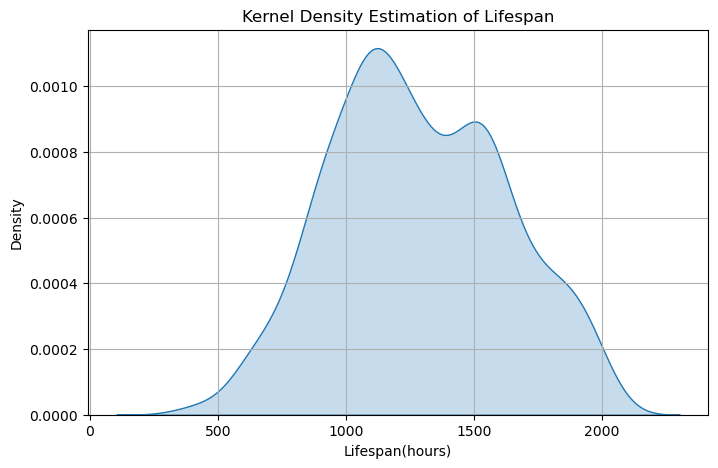

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df1 = df.copy()
plt.figure(figsize=(8, 5))
sns.kdeplot(df1['Lifespan'], fill=True)
plt.title('Kernel Density Estimation of Lifespan')
plt.xlabel("Lifespan(hours)")
plt.ylabel("Density")
plt.grid(True)
plt.savefig("../report/figures/fig-1.1-Lifespan_Kde.png", dpi=500, bbox_inches='tight')
plt.show()

### Kernel Density Estimation(Kde) Observations
1. This plot performs univariate analysis for 'Lifespan' feature
2. We can clearly see that the distribution of this plot is not perfectly normal
3. This distribution contains two peaks at values around '1100' hours and another one at '1500' hours
4. We can also see that there is no skewness in the data as the data is heavily centered around 2 peaks in the middle
5. **Multi-modal** nature of this graph comples us to use **GMM clustering** to found natural groupings as suggested by Jain's work(Jain, 2010).

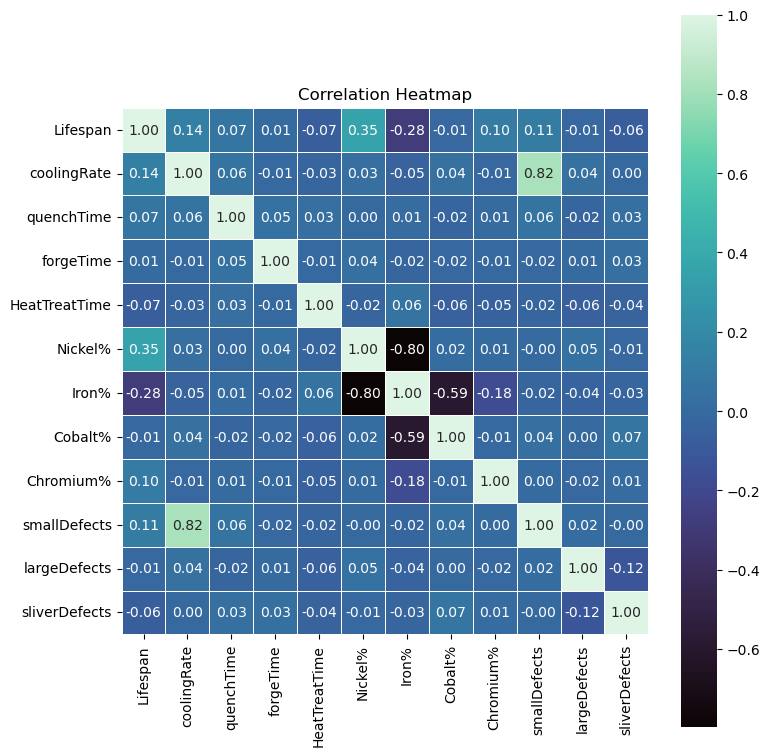

In [13]:
# plotting Person's correlation of 'Lifespan'

num_col = df1.select_dtypes(include=['float64','int64']).columns
corr_matrix = df1[num_col].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='mako', square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('../report/figures/fig-1.2-correlation_heatmap.png', dpi=500, bbox_inches='tight')
plt.show()

### Correlation Heatmap observations

1. We can clearly see there is a strong positive and negative correlation between 'Lifespan' and 'Nickel%' and 'Lifespan' and 'Iron%' respectively. So these two explain a lot about our target Lifespan
2. There seems be strong negative correlation among the following feature variables suggesting some form of multi-collinearity:
    a. 'Iron%' and'Nickel%' 
    b. 'Iron%' and 'Cobalt%'
3. Tree-based ensemble models are well adept at handling collinearity (Civantos-Gómez et al., 2021).

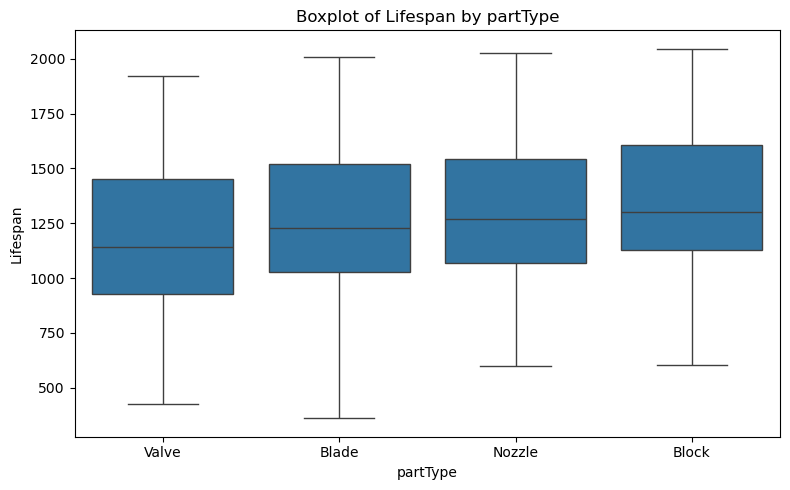

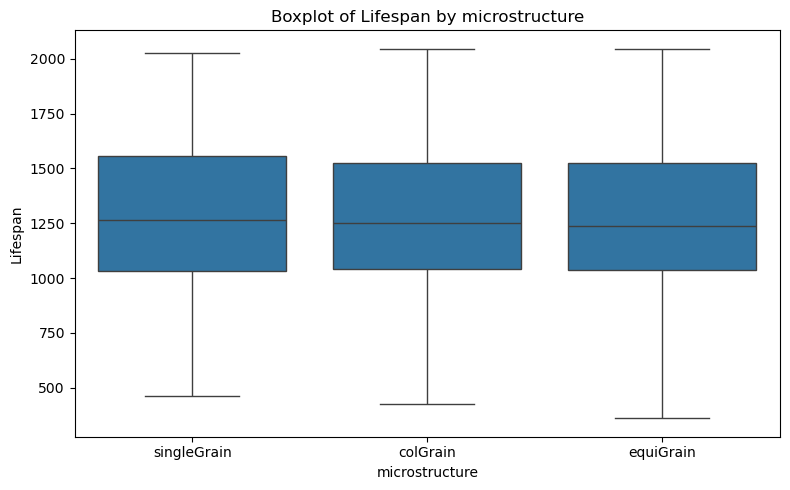

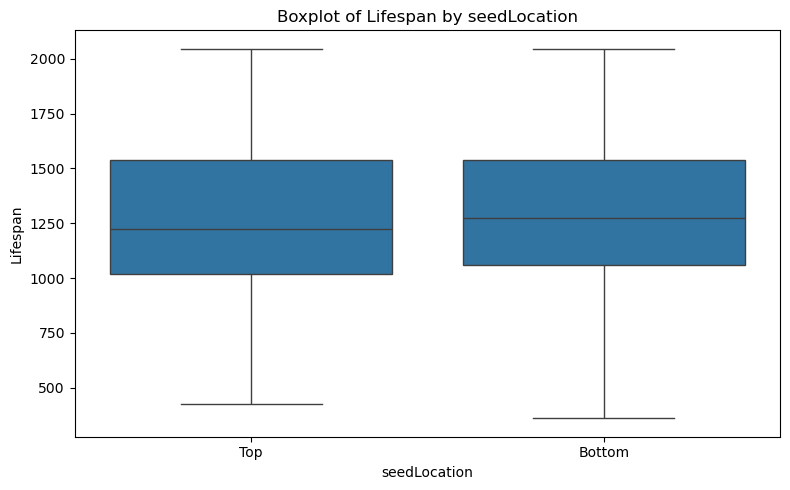

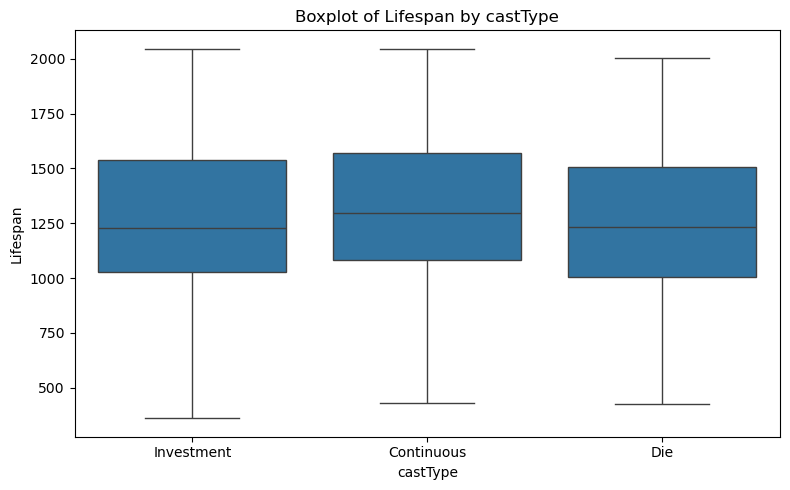

In [14]:
# Box-plots for categorical variables

cat_col = df1.select_dtypes(include=['object','category']).columns

for col in cat_col:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df1[col], y=df1['Lifespan'])
    plt.title(f'Boxplot of Lifespan by {col}')
    plt.ylabel('Lifespan')
    plt.xlabel(col)
    plt.tight_layout()
    plt.savefig('../report/figures/fig-1.3-boxplot.png', dpi=500, bbox_inches='tight')
plt.show()

### Boxplot Observations:

1. Boxplot shows of Lifespan with each categorical variable appears to be reasonaby symmetric with no extreme outliers
2. This suggests there is no need of aggressive data preprocessing like outlier removal and that standard modelling techniques could be used confidently
3. The relatively consistent spread of medians also tells that categorical variables are not dominated by isolated outliers

## Initial hypothesis:

**1.Regression Hypothesis**: The correlation heatmap indicated strong negative correlations between predictors variables like Iron% and Nickel%, suggesting potential multi-collinearity. Given these findings it is hypothesised that standard linear models will not be sufficient. We must look for models that are **robust to multi-collinearity** (like tree-based ensemble methods) or capable of caputring non-linear patterns (like SVR with RBF kernel). 
The observed variation in scales also necessitates feature scaling.

**2. Classification Hypothesis**: The Kernel density estimation plot clearly showed that the target variable. Lifespan, shows multi-model distribution around 1100 hours and 1500 hours. This shows there maybe several distinct sub-groups rather than just two threshold. Therefore it is hypothesised that applying **upsupervised clustering algorithms** (like GMM) to the data will identify more meaningful and data-driven class labels for classification